In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(-0.5, 224.5, 224.5, -0.5)

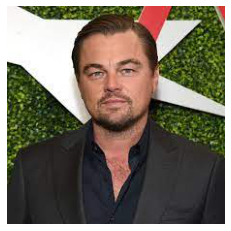

In [ ]:
file = '/content/drive/MyDrive/EyeGazing/ldc.jpg'
orig_img = load_img(file)
orig_img = img_to_array(orig_img)
orig_img= orig_img/255.0
plt.imshow(orig_img)
plt.axis("off")


In [ ]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import cv2


In [ ]:
img = cv2.imread(file)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/EyeGazing/face.xml')
faces = face_cascade.detectMultiScale(gray_img)



In [ ]:
for (x,y,w,h) in faces:
    cv2.rectangle(orig_img, (x,y), (x+w,y+h), (255,0,0),2)
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 224.5, 224.5, -0.5)

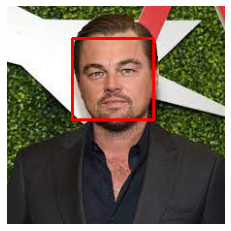

In [ ]:
for i in range(len(faces)):
  x=faces[i][0]
  y=faces[i][1]
  w=faces[i][2]
  h=faces[i][3]
  cv2.rectangle(orig_img, (x,y), (x+w,y+h), (255,0,0),2)

plt.imshow(orig_img)
plt.axis("off")



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


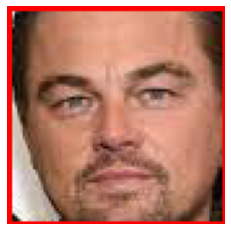

In [ ]:
for i in range(len(faces)):
  x=faces[i][0]
  y=faces[i][1]
  w=faces[i][2]
  h=faces[i][3]
  plt.imshow(orig_img[y:y+h,x:x+w])
  plt.axis("off")

In [ ]:
eye_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/EyeGazing/eye.xml')
eyes = eye_cascade.detectMultiScale(gray_img)

In [ ]:
eyes.shape

(2, 4)

In [ ]:
color = (0,0,0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 224.5, 224.5, -0.5)

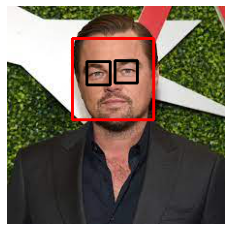

In [ ]:
for i in range(len(eyes)):
  x=eyes[i][0]
  y=eyes[i][1]
  w=eyes[i][2]
  h=eyes[i][3]
  cv2.rectangle(orig_img, (x,y), (x+w,y+h), color,2)

plt.imshow(orig_img)
plt.axis("off")